In [1]:
import pandas as pd
import numpy as np
import os
import time

from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt

<Axes: xlabel='is_duplicate'>

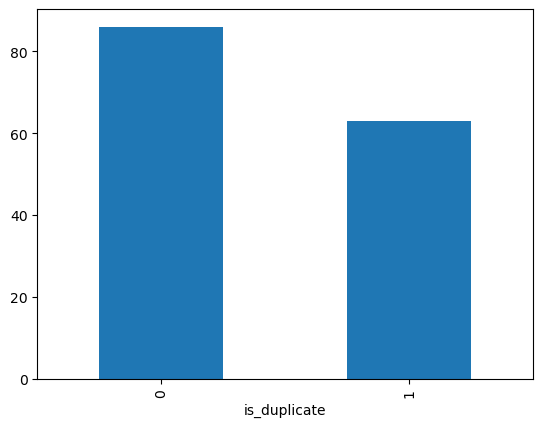

In [2]:
data = pd.read_csv('Input.csv')
data['is_duplicate'].value_counts().plot(kind='bar')

In [3]:
data['name'] = data.fn + ' ' + data.ln

In [4]:
import hashlib
import base64
data = data.assign(concat  = data.dob.astype(str) + data.gn + data.fn + data.ln)
data['hash']=data['concat'].astype(str).str.encode('UTF-8').apply(lambda x: base64.b64encode(hashlib.md5(x).digest()))
data
#data2=data
data.head()

,ln,dob,gn,fn,is_duplicate,name,concat,hash
0,SMITH JR,01-03-1968,F,WILLIAM,0,WILLIAM SMITH JR,01-03-1968FWILLIAMSMITH JR,b'6ooGhLMJb3lvX1et0d6Hvg=='
1,ROTHMEYER JR,01-03-1968,F,WILLIAM,0,WILLIAM ROTHMEYER JR,01-03-1968FWILLIAMROTHMEYER JR,b'5pksX5+lgv0GB35eNhpaYQ=='
2,BLAND III,21-02-1962,F,WILLIAM,1,WILLIAM BLAND III,21-02-1962FWILLIAMBLAND III,b'jazU8UoLH1tGMyuJ4eiGRg=='
3,BLAND JR,21-02-1962,F,BILL,0,BILL BLAND JR,21-02-1962FBILLBLAND JR,b'ZYaNELI/NJydwZK0f/EZ4g=='
4,BLAND,21-02-1962,F,WILLIAM,1,WILLIAM BLAND,21-02-1962FWILLIAMBLAND,b'yNF/iTxUfynEC6rF8UyOPw=='


In [5]:
#### A list of unique dates of birth and unique genders is obtained.

unique_dob = data.dob.unique()
unique_sex = data.gn.unique()
unique_hash = data.hash.unique()

In [6]:
pip install Distance


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for Distance: filename=Distance-0.1.3-py3-none-any.whl size=16281 sha256=8756b6708d66562077397f9e7d4a032d2ba73ea405f68bd048264b86357882b6
  Stored in directory: c:\users\lenovo\appdata\local\pip\cache\wheels\e2\5c\da\74b1353d54468703298f99740b79686e9314fe7384e0f97f56
Successfully built Distance
Note: you may need to restart the kernel to use updated packages.


  DEPRECATION: Building 'Distance' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'Distance'. Discussion can be found at https://github.com/pypa/pip/issues/6334


In [7]:
import distance

In [8]:
import time
start_h = time.time()
def deduplication_model(data, scoring_range = 10, step = 2):
    data['indices'] = list(range(len(data)))
    accuracy = []
    index = []
    final_step = 0
    for value in range(scoring_range):
        for i in unique_hash:
                sample = data[(data.hash == i)].reset_index(drop = True)
                for a in range(len(sample)):
                    comparison = sample[(sample.indices != sample.indices[a])].reset_index(drop = True)
                    scores = [distance.levenshtein(sample.name[a], comparison.name[x]) for x in range(len(comparison))]
                    compare = [comparison.indices[x] for x in range(len(comparison))]
                    try:
                        if sample.indices[a]>compare[scores.index(min(scores))]:
                            score = np.min(scores)
                            if score<=value:
                                index.append(sample.indices[a])
                    except ValueError:
                        pass
        prediction = []
        for k in range(len(data)):
            if data.indices[k] in index:
                prediction.append(1)
            else:
                prediction.append(0)

        data['prediction'] = prediction
        print('F1-score after ',value, 'iterations : ', f1_score(data.is_duplicate, data.prediction, average = 'macro'))
        accuracy.append(f1_score(data.is_duplicate, data.prediction, average = 'macro'))
        if len(accuracy)>1 and accuracy[-1] <= accuracy[-2]:
            final_step+=1
        if final_step>=step:    
            value = value-final_step
            break
    
    index = []
    for i in unique_hash:
            sample = data[(data.hash == i)].reset_index(drop = True)
            for a in range(len(sample)):
                comparison = sample[(sample.indices != sample.indices[a])].reset_index(drop = True)
                scores = [distance.levenshtein(sample.name[a], comparison.name[x]) for x in range(len(comparison))]
                compare = [comparison.indices[x] for x in range(len(comparison))]
                try:
                    if sample.indices[a]>compare[scores.index(min(scores))]:
                        score = np.min(scores)
                        if score<=value:
                            index.append(sample.indices[a])
                except ValueError:
                    pass
    prediction = []
    for k in range(len(data)):
        if data.indices[k] in index:
            prediction.append(1)
        else:
            prediction.append(0)
    return prediction, value

In [9]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size = 0.05, stratify = data.is_duplicate, random_state = 0)
train = train.reset_index(drop = True)
test = test.reset_index(drop = True)
performance, levenshtein_value_optimum = deduplication_model(train, scoring_range = 10, step = 3)

F1-score after  0 iterations :  0.6611481975967957
F1-score after  1 iterations :  0.6611481975967957
F1-score after  2 iterations :  0.6611481975967957
F1-score after  3 iterations :  0.6611481975967957


In [10]:
def deduplication_prediction(data, optimum_value):
    data['indices'] = list(range(len(data)))
    index = []
    for i in unique_hash:
            sample = data[(data.hash == i)].reset_index(drop = True)
            for a in range(len(sample)):
                comparison = sample[(sample.indices != sample.indices[a])].reset_index(drop = True)
                scores = [distance.levenshtein(sample.name[a], comparison.name[x]) for x in range(len(comparison))]
                compare = [comparison.indices[x] for x in range(len(comparison))]
                try:
                    if sample.indices[a]>compare[scores.index(min(scores))]:
                        score = np.min(scores)
                        if score<=optimum_value:
                            index.append(sample.indices[a])
                except ValueError:
                    pass
    prediction = []
    for k in range(len(data)):
        if data.indices[k] in index:
            prediction.append(1)
        else:
            prediction.append(0)
    return prediction

In [11]:
predictions = deduplication_prediction(test, levenshtein_value_optimum)


In [12]:
print('F1-score on test set:',accuracy_score(test.is_duplicate, predictions))


F1-score on test set: 0.625


In [13]:
train['prediction'] = performance
test['prediction'] = predictions
dataset = pd.concat([train, test], axis = 0)
dataset = dataset[(dataset.prediction != 1)].reset_index(drop = True).drop(labels = ['name', 'is_duplicate', 'prediction', 'indices'], axis = 1)

In [14]:
dataset.to_csv('Output_given.csv', index = False)
end_h = time.time()
tt2 = end_h - start_h
print('Time taken: ')
tt2

Time taken: 


83.83699679374695

In [15]:
data1 = pd.read_csv('Output_given.csv')
data1.head()

,ln,dob,gn,fn,concat,hash
0,GRIFFIN JR,07-05-1937,M,DARL,07-05-1937MDARLGRIFFIN JR,b'ADaHZJLqSAKFdPRFPsuybg=='
1,SHAILEE,09-02-1945,F,PATEL,09-02-1945FPATELSHAILEE,b'lWhlv8HXvuAGdlVBCEDAKQ=='
2,LARSON JR,09-06-1939,M,HAROLD,09-06-1939MHAROLDLARSON JR,b'PMxfVDvUPlKXwlXje9f+Tg=='
3,DEEPIKA,25-10-1953,F,PADUKON,25-10-1953FPADUKONDEEPIKA,b'K7lR+f6N3S4fCcd2hERxHA=='
4,LIND JR,20-01-1946,M,JOHN,20-01-1946MJOHNLIND JR,b'jDTrZWkqUueGy3XUJcRZdA=='


In [16]:
data1

,ln,dob,gn,fn,concat,hash
0,GRIFFIN JR,07-05-1937,M,DARL,07-05-1937MDARLGRIFFIN JR,b'ADaHZJLqSAKFdPRFPsuybg=='
1,SHAILEE,09-02-1945,F,PATEL,09-02-1945FPATELSHAILEE,b'lWhlv8HXvuAGdlVBCEDAKQ=='
2,LARSON JR,09-06-1939,M,HAROLD,09-06-1939MHAROLDLARSON JR,b'PMxfVDvUPlKXwlXje9f+Tg=='
3,DEEPIKA,25-10-1953,F,PADUKON,25-10-1953FPADUKONDEEPIKA,b'K7lR+f6N3S4fCcd2hERxHA=='
4,LIND JR,20-01-1946,M,JOHN,20-01-1946MJOHNLIND JR,b'jDTrZWkqUueGy3XUJcRZdA=='
...,...,...,...,...,...,...
97,GRIFFIN JR,10-07-1937,M,DARL,10-07-1937MDARLGRIFFIN JR,b'IMALmkqtvKIMgZ6Nf4lNuQ=='
98,RAJ,10-05-1945,M,SHARMA,10-05-1945MSHARMARAJ,b'tXMD622WenXznG2Pkjf13Q=='
99,SALTER JR,01-03-1968,F,WILLIAM,01-03-1968FWILLIAMSALTER JR,b'voMlZ1YMCW9iIoTbdexiDw=='
100,MELVIN JR,07-10-1937,M,HAROLD,07-10-1937MHAROLDMELVIN JR,b'sVz+K3QGYtBMEiOIKJMK7Q=='
